# PUDL_26 AI CUP 2025 秋季賽-電腦斷層主動脈瓣物件偵測-訓練模型
https://tbrain.trendmicro.com.tw/Competitions/Details/42

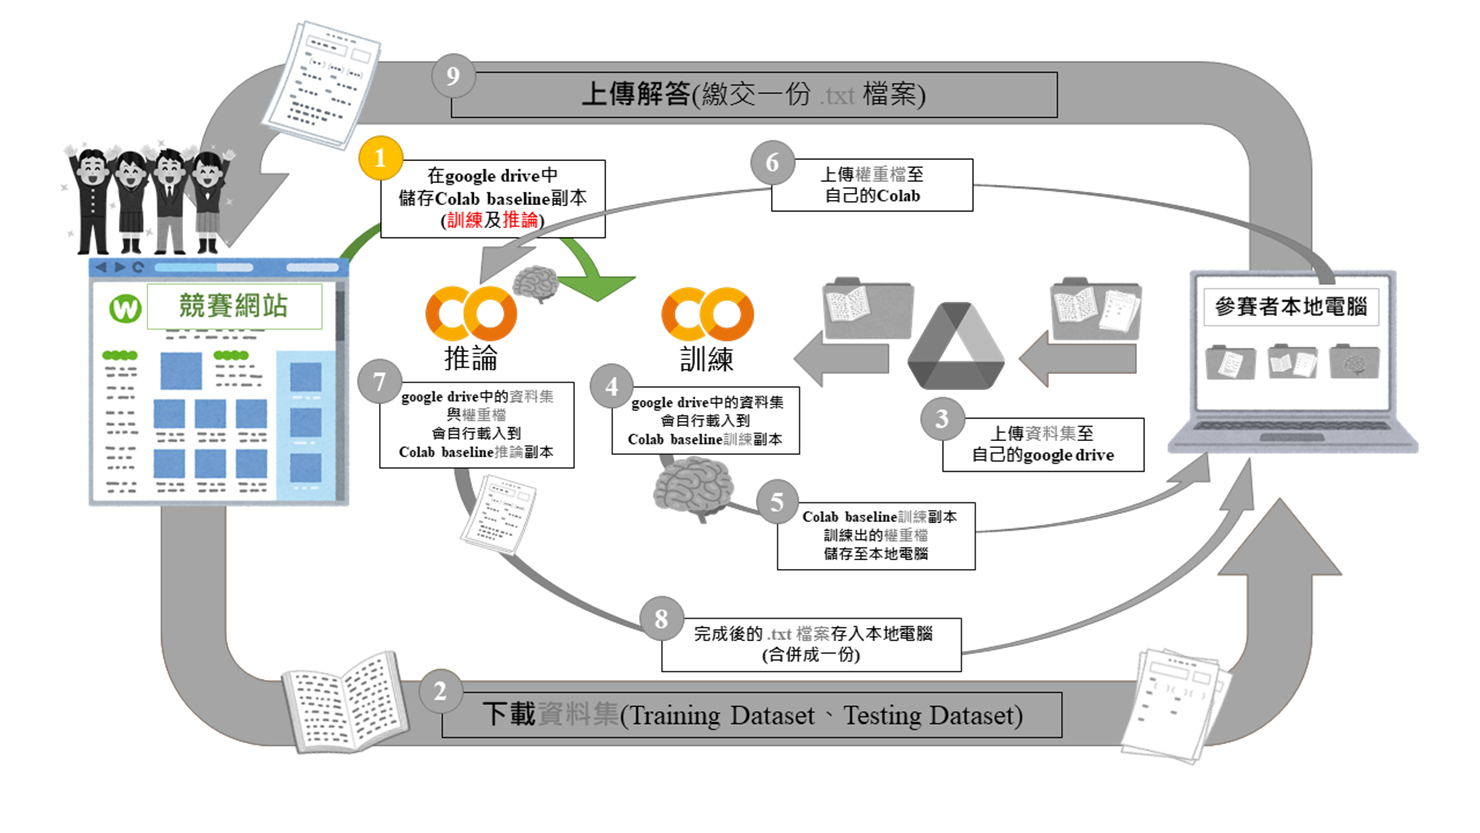

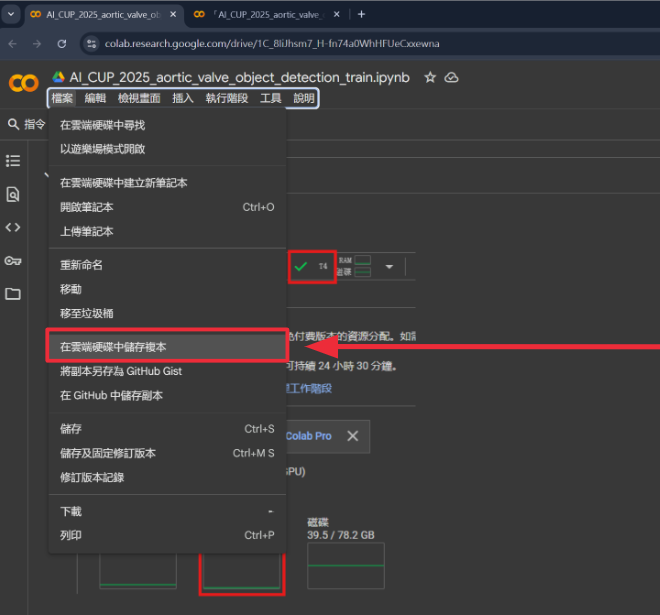

## 1.設置環境

從畫面右上角確認有使用到GPU

Colab區塊左方有綠色勾代表執行完成且成功 image.png


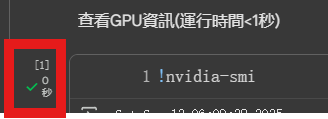

區塊左方有圈在轉代表執行中 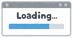

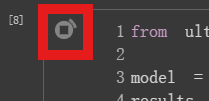

區塊左方有紅色驚嘆號代表運行錯誤 image.png

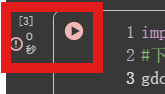

### 查看GPU資訊(運行時間<1秒)

In [ ]:
!nvidia-smi

### 確保不會出現編碼錯誤

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

### 下載YOLOv12套件

In [ ]:
!pip install ultralytics
import ultralytics
ultralytics.checks()

## 2.下載資資料集和 .yaml 檔

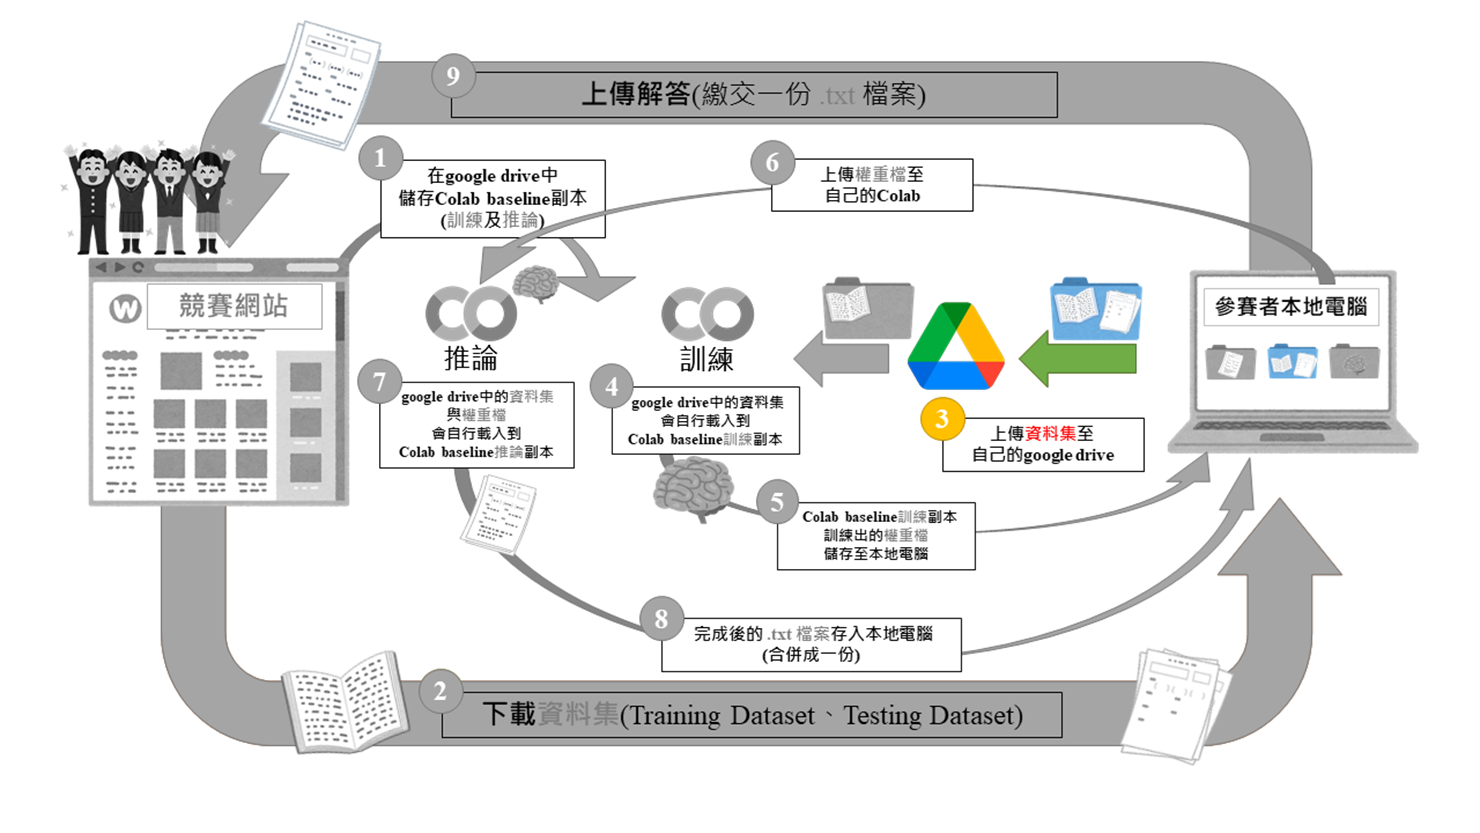

### 資料集
* training_image.zip https://drive.google.com/file/d/1ZWbSTHdy2qIAX12hwbpV6UcKd3hO5rz8/view?usp=sharing
* training_label.zip https://drive.google.com/file/d/1CHWSAF-y4W9ScKrISqhNpsC-xyB0EAGq/view?usp=sharing
* aortic_valve_colab.yaml https://drive.google.com/file/d/1wt9IGcnHki96sHvoVY96Td3vXhyw9Nhz/view?usp=sharing

In [ ]:
%%bash
gdown https://drive.google.com/uc?id=1ZWbSTHdy2qIAX12hwbpV6UcKd3hO5rz8
unzip training_image.zip
rm training_image.zip

In [ ]:
%%bash
gdown https://drive.google.com/uc?id=1CHWSAF-y4W9ScKrISqhNpsC-xyB0EAGq
unzip training_label.zip
rm training_label.zip

In [ ]:
!gdown https://drive.google.com/uc?id=1wt9IGcnHki96sHvoVY96Td3vXhyw9Nhz

### 移動檔案(透過下方程式，執行時間<1分鐘)


* 此範例將前30筆資料用於訓練，後20筆資料用於驗證，參賽者可在程式中53行及56行更改比例

* 因為Colab運算資源有限此處只採用有標註檔的圖片，其餘圖片也可以自行修改程式利用

* 前30筆資料的圖片全部移動至./datasets/train/images，
* 前30筆資料的標註全部移動至./datasets/train/labels，
* 後20筆資料的圖片全部移動至./datasets/val/images，
* 後20筆資料的標註全部移動至./datasets/val/labels。


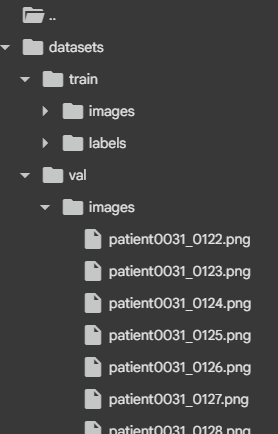

In [ ]:
#移動檔案
import os
import shutil
def find_patient_root(root):
    """往下找，直到找到含有 patientXXXX 的資料夾"""
    for dirpath, dirnames, filenames in os.walk(root):
        if any(d.startswith("patient") for d in dirnames):
            return dirpath
    return root  # fallback

# 解壓縮到固定資料夾
if not os.path.isdir("./training_image") and os.path.exists("training_image.zip"):
    os.makedirs("./training_image", exist_ok=True)
    !unzip -q training_image.zip -d ./training_image

if not os.path.isdir("./training_label") and os.path.exists("training_label.zip"):
    os.makedirs("./training_label", exist_ok=True)
    !unzip -q training_label.zip -d ./training_label

IMG_ROOT = find_patient_root("./training_image")
LBL_ROOT = find_patient_root("./training_label")

print("IMG_ROOT =", IMG_ROOT)
print("LBL_ROOT =", LBL_ROOT)

# 建立並清空輸出資料夾（若存在）
def ensure_clean_dir(path):
    if os.path.isdir(path):
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

ensure_clean_dir("./datasets/train/images")
ensure_clean_dir("./datasets/train/labels")
ensure_clean_dir("./datasets/val/images")
ensure_clean_dir("./datasets/val/labels")

def move_patients(start, end, split):
    for i in range(start, end + 1):
        patient = f"patient{i:04d}"
        img_dir = os.path.join(IMG_ROOT, patient)
        lbl_dir = os.path.join(LBL_ROOT, patient)
        if not os.path.isdir(lbl_dir):
            continue

        for fname in os.listdir(lbl_dir):
            if not fname.endswith(".txt"):
                continue

            label_path = os.path.join(lbl_dir, fname)
            base, _ = os.path.splitext(fname)  # 取出檔名不含副檔名
            img_path = os.path.join(img_dir, base + ".png")
            if not os.path.exists(img_path):
                print(f"找不到對應圖片: {img_path}")
                continue

            shutil.copy2(img_path, f"./datasets/{split}/images/")
            shutil.copy2(label_path, f"./datasets/{split}/labels/")

# patient0001~0030 → train
move_patients(1, 30, "train")

# patient0031~0050 → val
move_patients(31, 50, "val")

print("完成移動！")

### 確認檔案是否成功移動 image.png

如果資料數量符合下圖數量代表移動成功

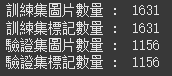

#=====================================================

In [ ]:
!ls

In [ ]:
print('訓練集圖片數量 : ',len(os.listdir("./datasets/train/images")))
print('訓練集標記數量 : ',len(os.listdir("./datasets/train/labels")))
print('驗證集圖片數量 : ',len(os.listdir("./datasets/val/images")))
print('驗證集標記數量 : ',len(os.listdir("./datasets/val/labels")))

## 3.訓練模型(運行時間約15分鐘)

### 執行後依序有Epoch在跑代表成功

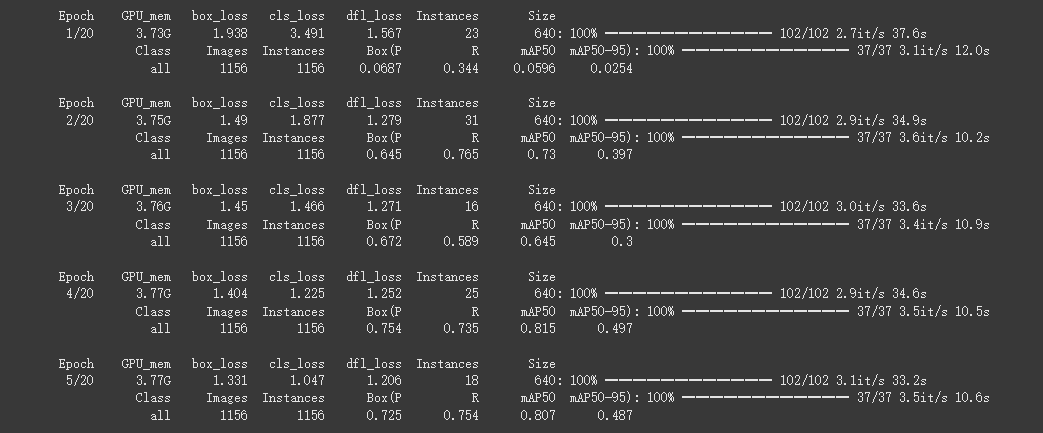

In [ ]:
from ultralytics import YOLO
#模型參數參考網址:https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/default.yaml
model = YOLO('yolo12n.pt') #初次訓練使用YOLO官方的預訓練模型，如要使用自己的模型訓練可以將'yolo12n.pt'替換掉


In [ ]:
#先跑看看, 2個epoch
results = model.train(data="./aortic_valve_colab.yaml",
            epochs=2, #先跑2個epoch
            batch=16, #batch_size
            imgsz=640, #圖片大小640*640
            device=0 #使用GPU進行訓練
            )

In [ ]:
#跑更多,20個epoch
results = model.train(data="./aortic_valve_colab.yaml",
            epochs=20, #跑20個epoch
            batch=16, #batch_size
            imgsz=640, #圖片大小640*640
            device=0 #使用GPU進行訓練
            )

###
訓練完左方檔案會有run資料夾，此份Colab主要目標是得到best.pt用於下一份Colab進行預測image.png

(!!如果有重複訓練**請下載最後成功**的train編號資料夾)

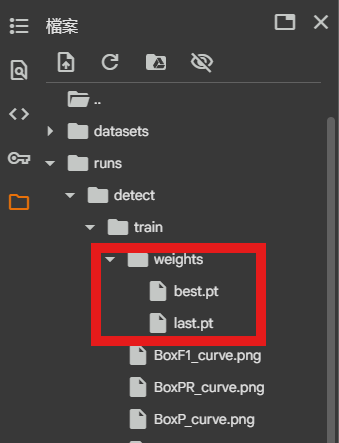

## 4.下載訓練完的模型

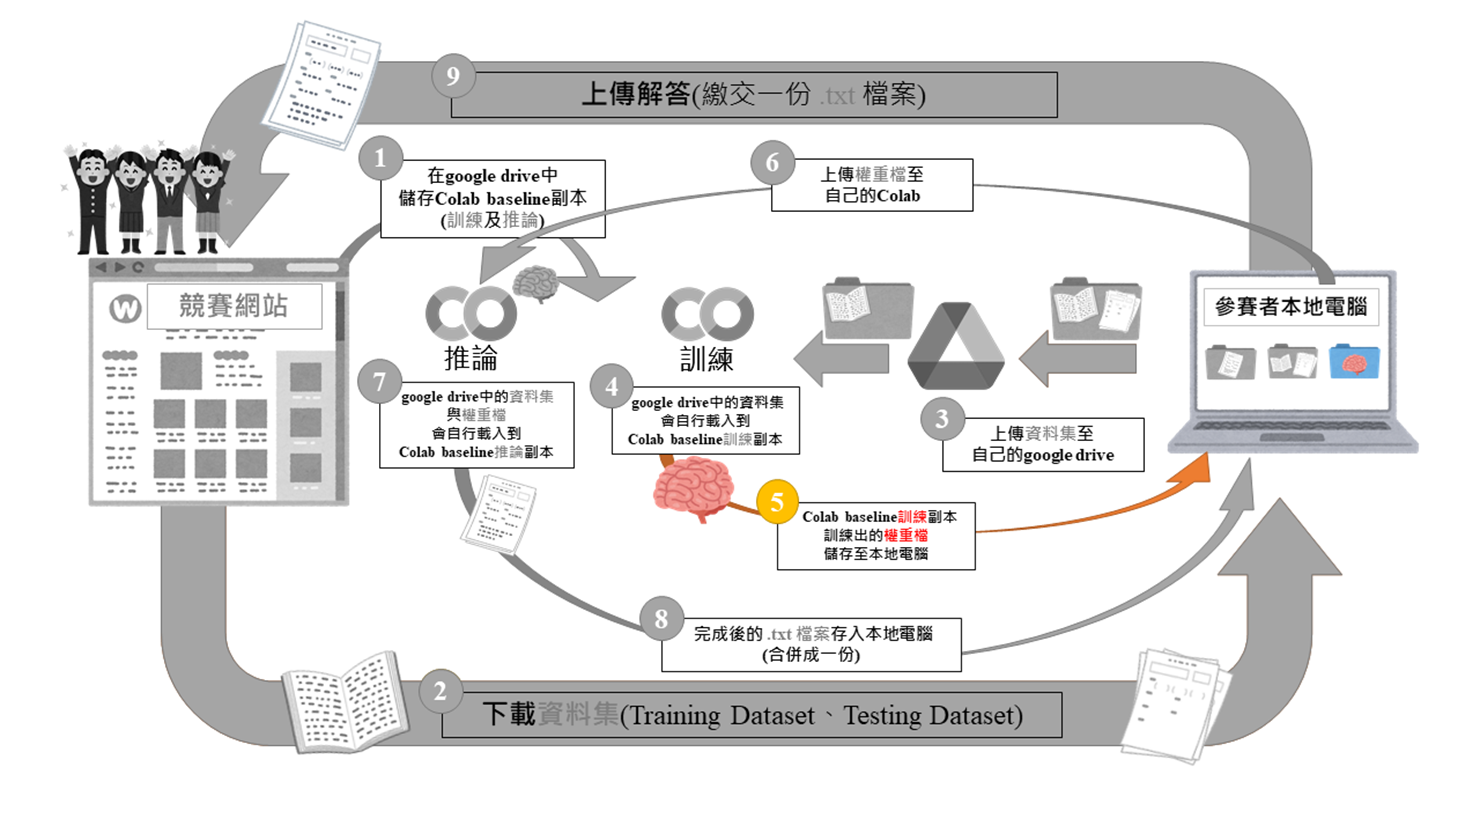

#### 下載訓練完的模型權重

右鍵直接下載best.pt和last.pt image.png

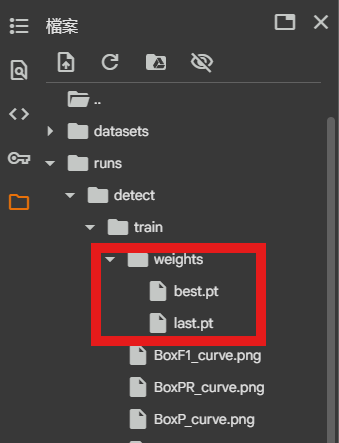